# Competitor Comparison

The purpose of this notebook is to compare the debiased machine learning Thompson sampling algorithm (DML-TS-NNR) to several competitors.
The data forms a rectangular array of data.
The results from this simulation are in the appendix.

This notebook contains three separate simulations that compare these methods.
In the first simulation, the standard Thompson sampling assumptions hold,
and the users are assumed to be homogeneous in the sense that their advantage functions (causal effects) are the same.
The second situation is similar, but users are heterogeneous in the sense that they have different advantage functions.
In the third simulation, the data-generating mechanism is much more complex.
In addition to being nonlinear, it also includes effects for users and time.
Consequently, only the DML-TS-NNR method performs well in this setting.

# Shared Setup

In [1]:
# Generic imports
import pandas as pd
import numpy as np
import scipy
import scipy.sparse
from scipy.stats import ttest_1samp
import matplotlib.pyplot as plt
import seaborn as sns
from river import linear_model
import copy
from multiprocessing import Pool, cpu_count
import pickle
import tensorflow as tf
import keras
from keras import layers, regularizers

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-uv6llv3u because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.
2024-01-18 16:06:50.848008: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-18 16:06:54.256477: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different com

In [2]:
# Imports from this project
from models.models import OracleTS, StandardTS, ActionCenteredTS, DmlTS, IntelligentPooling, UserLaplacian
from models.river_wrapper import RiverBatchEstimator
from models.bagging_mod import BaggingRegressor
from models.utils import find_neighbors
from simulations.data_generator import DataGenerator

In [3]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)
plt.rcParams['font.family'] = 'sans-serif'

In [4]:
# Simulation setup: try some different values
N_STAGES = 100
# N_OBSERVATIONS = N_STAGES * (N_STAGES + 1) // 2
N = N_STAGES
T = N_STAGES
THETA = np.array([1., 0.5, -4.])
CONTEXT_DIM = 2
EXTRA_CONTEXT_DIM = 2
LINEAR_BASELINE_COEF = np.array([2., -2., 3.])
THETA_TIME_INIT = np.array([-2., -4., 6.])
P = THETA.size
n_jobs = 25
REPS = 50
N_NEIGHBORS = 5

In [5]:
def get_max_norm(x):
    squared_norms = (x**2).sum(axis=1)
    norms = np.sqrt(squared_norms)
    max_norm = np.max(norms)
    return max_norm

def get_max_norm_for_pairs(x, pairs):
    x_diffs = x[pairs[0]] - x[pairs[1]]
    max_norm = get_max_norm(x_diffs)
    return max_norm

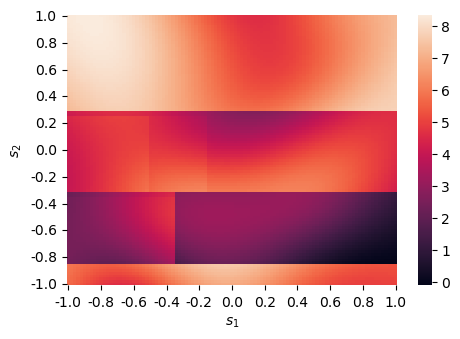

In [6]:
homogeneous_data_generator = DataGenerator(n_max=N, t_max=T, assumptions="homogeneous", linear_baseline_coef=LINEAR_BASELINE_COEF, random_seed=1)
homogeneous_data_generator = homogeneous_data_generator.sample_theta(theta_base=THETA)

heterogeneous_data_generator = DataGenerator(n_max=N, t_max=T, assumptions="heterogeneous", linear_baseline_coef=LINEAR_BASELINE_COEF, random_seed=1)
heterogeneous_data_generator = heterogeneous_data_generator.sample_theta(theta_base=THETA)

nonlinear_data_generator = DataGenerator(n_max=N, t_max=T, assumptions="nonlinear", random_seed=3, nonlinear_scale=1.)  # Seed chosen for its interesting nonlinear relationships
nonlinear_data_generator = nonlinear_data_generator.sample_theta(theta_base=THETA, theta_time_init=THETA_TIME_INIT)

# Baseline Reward
num_vals = 101
s1_vals = np.round(np.linspace(-1., 1., num=num_vals), 2)
s2_vals = np.round(np.linspace(-1., 1., num=num_vals), 2)
s1_vals_repped, s2_vals_repped = np.meshgrid(s1_vals, s2_vals)
context_values = np.vstack([s1_vals_repped.flatten(), s2_vals_repped.flatten()]).T
baseline_vals = nonlinear_data_generator._nonlinear_baseline_function(context_values, scale=nonlinear_data_generator.nonlinear_scale)
heatmap_min = np.min(baseline_vals)
heatmap_max = np.max(baseline_vals)

baseline_vals_df = pd.DataFrame(
    data=baseline_vals.reshape((num_vals, num_vals)),
    index=s1_vals,
    columns=s2_vals).sort_index(ascending=False)

fig, ax = plt.subplots(figsize=(5, 3.5))
ax = sns.heatmap(baseline_vals_df, xticklabels=10, yticklabels=10, ax=ax)
plt.xlabel("$s_{1}$")
plt.ylabel("$s_{2}$")
# plt.title("Baseline Reward as a Function of State")
fig.tight_layout()
fig.savefig("figures/baseline_reward.png")
plt.show()

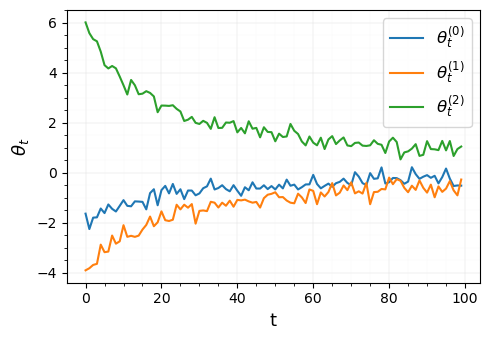

In [7]:
# Time-specifc thetas
fig, ax = plt.subplots(figsize=(5, 3.5))
for i in range(THETA.size):
    label = "$\\theta^{(idx)}_{t}$".replace("idx", str(i))
    ax.plot(nonlinear_data_generator.theta_time[:, i], alpha=1, label=label)
ax.grid(which='major', color='#DDDDDD', linewidth=0.3)
ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.3)
ax.minorticks_on()
ax.set_xlabel("t", fontsize=13)
ax.set_ylabel("$\\theta_{t}$", fontsize=13)
# plt.title("Values of $\\theta_{time}$ Plotted Over Time")
ax.legend(fontsize=12)
fig.tight_layout()
fig.savefig("figures/theta_time.png")
plt.show()

2024-01-18 16:07:14.983677: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
50/50 [==============================] - 2s 4ms/step - loss: 2.5881 - val_loss: 1.2925
Epoch 2/20
50/50 [==============================] - 0s 2ms/step - loss: 1.2028 - val_loss: 1.1024
Epoch 3/20
50/50 [==============================] - 0s 1ms/step - loss: 1.1281 - val_loss: 1.0924
Epoch 4/20
50/50 [==============================] - 0s 1ms/step - loss: 1.1245 - val_loss: 1.0717
Epoch 5/20
50/50 [==============================] - 0s 2ms/step - loss: 1.1094 - val_loss: 1.0486
Epoch 6/20
50/50 [==============================] - 0s 1ms/step - loss: 1.1022 - val_loss: 1.0706
Epoch 7/20
50/50 [==============================] - 0s 1ms/step - loss: 1.1011 - val_loss: 1.0869
Epoch 8/20
50/50 [==============================] - 0s 1ms/step - loss: 1.0848 - val_loss: 1.0355
Epoch 9/20
50/50 [==============================] - 0s 1ms/step - loss: 1.0811 - val_loss: 1.1524
Epoch 10/20
50/50 [==============================] - 0s 2ms/step - loss: 1.1008 - val_loss: 1.0541
Epoch 11/20
50/50 [

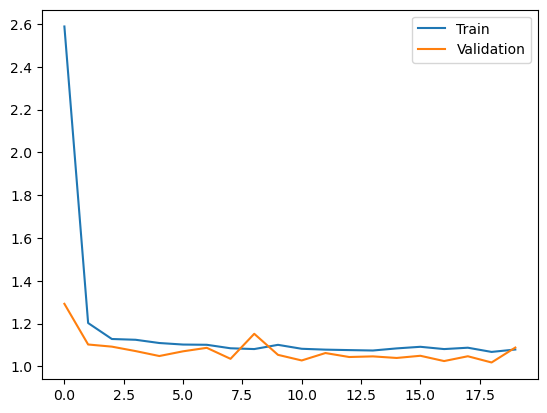

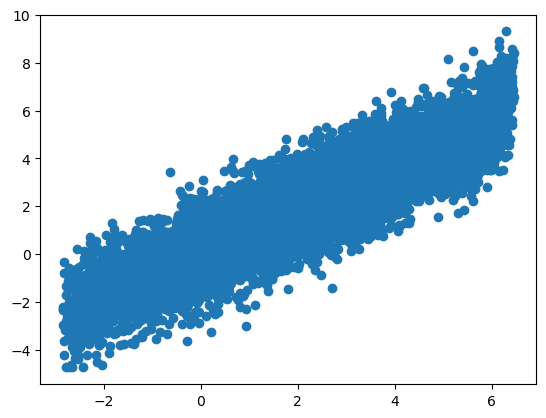

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......input_layer
.........vars
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2024-01-18 16:07:21           64
config.json                                    2024-01-18 16:07:21         2589
variables.h5                                   2024-01-18 16:07:21        19128
Keras model archive loading:
File Name                                             Modified             Size
metadata.json                                  2024-01-18 16:07:20           64
config.json                                    2024-01-18 16:07:20         2589
variables.h5                                 

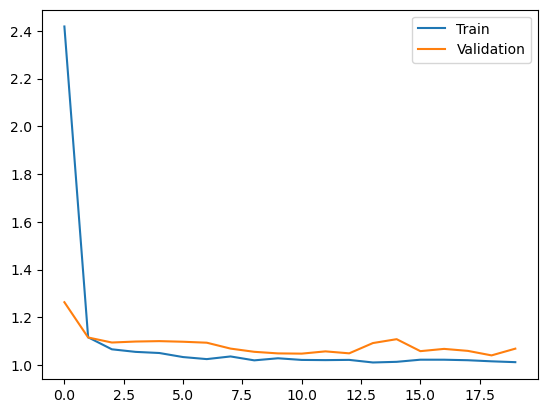

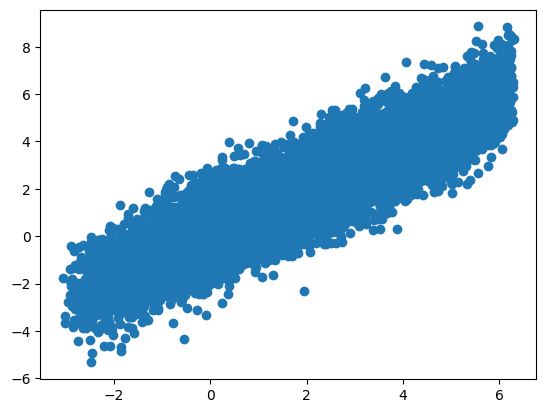

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......input_layer
.........vars
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2024-01-18 16:07:23           64
config.json                                    2024-01-18 16:07:23         2591
variables.h5                                   2024-01-18 16:07:23        19128
Keras model archive loading:
File Name                                             Modified             Size
metadata.json                                  2024-01-18 16:07:22           64
config.json                                    2024-01-18 16:07:22         2591
variables.h5                                 

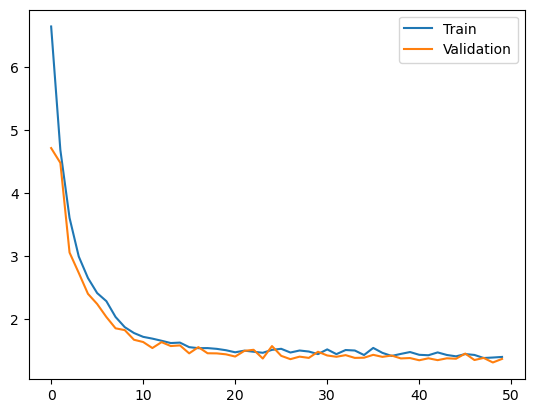

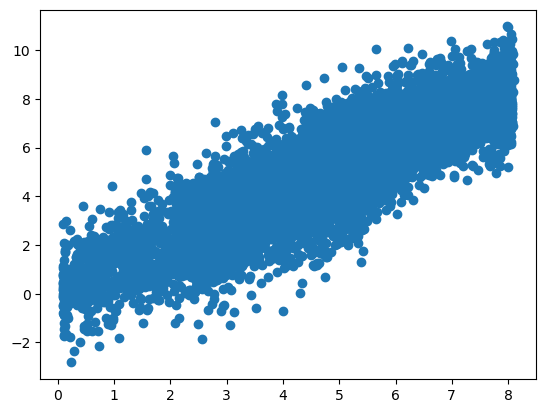

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......input_layer
.........vars
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2024-01-18 16:07:28           64
config.json                                    2024-01-18 16:07:28         2591
variables.h5                                   2024-01-18 16:07:28        19128
Keras model archive loading:
File Name                                             Modified             Size
metadata.json                                  2024-01-18 16:07:28           64
config.json                                    2024-01-18 16:07:28         2591
variables.h5                                 

In [8]:
%%time
# Neural network stuff
nn_input_dim = CONTEXT_DIM + EXTRA_CONTEXT_DIM

featurizer_nn_models = []
for i, data_generator in enumerate([homogeneous_data_generator, heterogeneous_data_generator, nonlinear_data_generator]):
    # Create data
    data_generator = data_generator.generate_all_contexts(context_dim=CONTEXT_DIM, extra_context_dim=EXTRA_CONTEXT_DIM)
    X_train, y_train = data_generator.generate_baselines_for_nn()
    
    data_generator = data_generator.reset()
    data_generator = data_generator.generate_all_contexts(context_dim=CONTEXT_DIM, extra_context_dim=EXTRA_CONTEXT_DIM)
    X_validation, y_validation = data_generator.generate_baselines_for_nn()
    
    # Train model
    penalty = 0.001
    nn_output_dim = 10
    model = keras.Sequential(
        [
            keras.Input(shape=(nn_input_dim,), name="input"),
            layers.Dense(10, activation="relu", name="layer1", kernel_regularizer=regularizers.l2(penalty)),
            layers.Dense(20, activation="relu", name="layer2", kernel_regularizer=regularizers.l2(penalty)),
            layers.Dense(20, activation="tanh", name="layer3", kernel_regularizer=regularizers.l2(penalty)),
            layers.Dense(nn_output_dim, activation="tanh", name="layer4", kernel_regularizer=regularizers.l2(penalty)),
            layers.Dense(1, name="output", kernel_regularizer=regularizers.l2(penalty)),
        ]
    )
    opt = keras.optimizers.Adam(learning_rate=0.01)
    model.compile(loss="mse", optimizer=opt)
    history = model.fit(
        X_train,
        y_train,
        batch_size=200,
        validation_data=(X_validation, y_validation),
        epochs=50 if i == 2 else 20,
        verbose=1
    )
    
    plt.plot(history.history['loss'], label="Train")
    plt.plot(history.history['val_loss'], label="Validation")
    plt.legend()
    plt.show()

    preds_validation = model(X_validation)
    plt.scatter(preds_validation, y_validation)
    plt.show()
    
    # Featurizer model
    featurizer_nn_model = keras.Model(
        inputs=model.input,
        outputs=model.get_layer("layer4").output)
    
    featurizer_nn_models.append(copy.deepcopy(featurizer_nn_model))

homogeneous_featurizer_nn_model = featurizer_nn_models[0]
heterogeneous_featurizer_nn_model = featurizer_nn_models[1]
nonlinear_featurizer_nn_model = featurizer_nn_models[2]

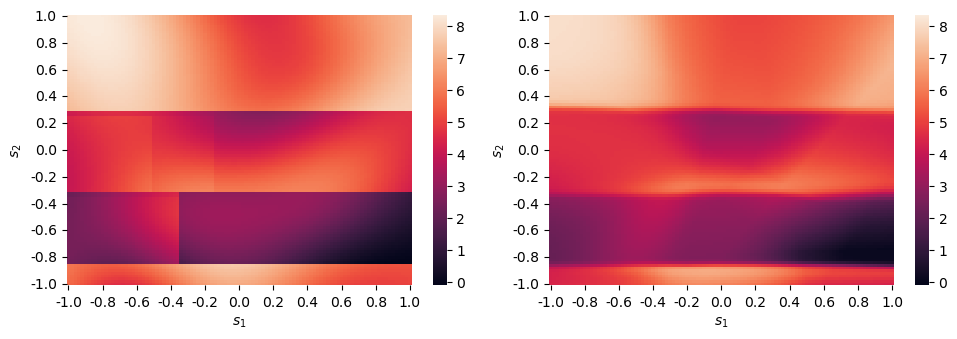

In [9]:
# Baseline Reward
num_vals = 101
s1_vals = np.round(np.linspace(-1., 1., num=num_vals), 2)
s2_vals = np.round(np.linspace(-1., 1., num=num_vals), 2)
s1_vals_repped, s2_vals_repped = np.meshgrid(s1_vals, s2_vals)
context_values = np.vstack([s1_vals_repped.flatten(), s2_vals_repped.flatten()]).T
baseline_vals = nonlinear_data_generator._nonlinear_baseline_function(context_values, scale=nonlinear_data_generator.nonlinear_scale)

baseline_vals_df = pd.DataFrame(
    data=baseline_vals.reshape((num_vals, num_vals)),
    index=s1_vals,
    columns=s2_vals).sort_index(ascending=False)

fig, ax = plt.subplots(1, 2, figsize=(10, 3.5))
sns.heatmap(baseline_vals_df, vmin=heatmap_min, vmax=heatmap_max, xticklabels=10, yticklabels=10, ax=ax[0])
ax[0].set_xlabel("$s_{1}$")
ax[0].set_ylabel("$s_{2}$")

nn_context_values = np.hstack([context_values, np.zeros_like(context_values)])
nn_baseline_vals = model(nn_context_values).numpy()
nn_baseline_vals_df = pd.DataFrame(
    data=nn_baseline_vals.reshape((num_vals, num_vals)),
    index=s1_vals,
    columns=s2_vals).sort_index(ascending=False)

sns.heatmap(nn_baseline_vals_df, vmin=heatmap_min, vmax=heatmap_max, xticklabels=10, yticklabels=10, ax=ax[1])
ax[1].set_xlabel("$s_{1}$")
ax[1].set_ylabel("$s_{2}$")

fig.tight_layout()
fig.savefig("figures/nn_baseline_reward_comparison.png")
plt.show()

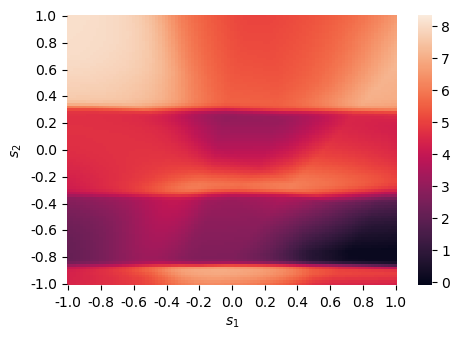

In [10]:
fig, ax = plt.subplots(figsize=(5, 3.5))
ax = sns.heatmap(nn_baseline_vals_df, vmin=heatmap_min, vmax=heatmap_max, xticklabels=10, yticklabels=10, ax=ax)
plt.xlabel("$s_{1}$")
plt.ylabel("$s_{2}$")
# plt.title("Baseline Reward as a Function of State")
fig.tight_layout()
fig.savefig("figures/nn_baseline_reward.png")
plt.show()

In [11]:
# This determines the plotting order
non_oracle_method_names = [
    "IntelPooling",
    "DML-TS-NNR-BLM",
    "DML-TS-NNR",
    "DML-TS-SU",
    "AC",
    "Standard",
    "Neural-Linear",
    "NNR-Linear"
]

def create_reward_dict(data_generator, nn, seed):
    np.random.seed(seed)
    user_pairs, L_user = find_neighbors(data_generator.theta_user, N_NEIGHBORS)
    time_pairs, L_time = find_neighbors(data_generator.theta_time, N_NEIGHBORS)
    
    # Doubling these values to make them more reasonable
    d_user = get_max_norm(data_generator.theta_user) * 2
    d_time = get_max_norm(data_generator.theta_time) * 2
    b_user = get_max_norm_for_pairs(data_generator.theta_user, user_pairs) * 2
    b_time = get_max_norm_for_pairs(data_generator.theta_time, time_pairs) * 2
    bagged_lm = RiverBatchEstimator(
        BaggingRegressor(
            linear_model.LinearRegression(l2=1e-8, intercept_lr=0.1),
            n_models=10,
            subsample=0.8
        )
    )

    # Set covariances
    cov_epsilon = 1e-18
    user_cov = np.cov(data_generator.theta_user.T)
    if user_cov.sum() < cov_epsilon:
        user_cov += cov_epsilon * np.eye(user_cov.shape[0])
    time_cov = np.cov(data_generator.theta_time.T)
    if time_cov.sum() < cov_epsilon:
        time_cov += cov_epsilon * np.eye(time_cov.shape[0])

    nn_numpy = lambda x: nn(x).numpy()
    non_oracle_methods_dict = {
        "IntelPooling": IntelligentPooling(N, T, P, DataGenerator._featurize, user_cov=user_cov, time_cov=time_cov),
        "DML-TS-NNR": DmlTS(N, T, P, DataGenerator._featurize, L_user, L_time, user_cov=user_cov, time_cov=time_cov, b_user=b_user, b_time=b_time, d_user=d_user, d_time=d_time, n_neighbors=N_NEIGHBORS),
        "DML-TS-NNR-BLM": DmlTS(N, T, P, DataGenerator._featurize, L_user, L_time, user_cov=user_cov, time_cov=time_cov, b_user=b_user, b_time=b_time, d_user=d_user, d_time=d_time, ml_interactions=True, ml_model=bagged_lm, n_neighbors=N_NEIGHBORS),
        "DML-TS-SU": DmlTS(1, T, P, DataGenerator._featurize, L_user, L_time, user_cov=user_cov, time_cov=time_cov, b_user=b_user, b_time=b_time, d_user=d_user, d_time=d_time, n_neighbors=N_NEIGHBORS, pool_users=False),
        "AC": ActionCenteredTS(N, T, P, DataGenerator._featurize),
        "Standard": StandardTS(N, T, P, DataGenerator._featurize),
        "Neural-Linear": StandardTS(N, T, P, DataGenerator._featurize, nn=nn_numpy, nn_dim=nn_output_dim),
        "NNR-Linear": UserLaplacian(N, T, P, DataGenerator._featurize, L_user, user_cov=user_cov),
    }
    methods_dict = copy.copy(non_oracle_methods_dict)
    methods_dict["Oracle"] = OracleTS(N, T, THETA, data_generator.theta_user, data_generator.theta_time, DataGenerator._featurize)
    
    # Dictionary for storing rewards
    rewards_dict = {k:np.zeros((N, T)) for k in methods_dict}

    # Generate context vectors that we'll use for all models
    data_generator = data_generator.generate_all_contexts(context_dim=CONTEXT_DIM, extra_context_dim=EXTRA_CONTEXT_DIM)

    # Iterate through methods
    for method_name, method in methods_dict.items():
        rewards = []
        data_generator = data_generator.reset()
        method.reset()

        while not data_generator.finished:
            # Randomly samples action from current policy
            context, context_extra, user_idx, time_idx = data_generator.get_current_context()
            action = method.sample_action(context, user_idx, time_idx)

            # Plays action and returns reward
            reward = data_generator.play_action(action)
            rewards_dict[method_name][user_idx, time_idx] = reward

            # Update method inferences
            method.update(context, context_extra, user_idx, time_idx, action, reward)
                
    return rewards_dict

In [12]:
def run_simulation(data_generator, nn, REPS=REPS, n_jobs=cpu_count()):    
    # Perform whole simulation REPS times
    with Pool(min(REPS, n_jobs)) as p:
        rewards_list_of_dicts = p.starmap(create_reward_dict, zip([data_generator]*REPS, [nn]*REPS, range(REPS)))
        
    rewards_dict = {}
    method_names = list(rewards_list_of_dicts[0].keys())
    non_oracle_method_names = list(set(method_names) - set(["Oracle"]))
    for method_name in method_names:
        rewards_dict[method_name] = np.asarray([
            rewards_list_of_dicts[i][method_name]
            for i in range(REPS)])
                
    return rewards_dict

In [13]:
def get_avg_time_reward(a):
    return a.mean(axis=1)

def plot_rewards_dict(rewards_dict, assumptions):
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax0 = ax[0]
    ax1 = ax[1]
    
    # Method names
    # non_oracle_method_names = set(rewards_dict.keys()) - {"Oracle",}
    # non_oracle_method_names = sorted(list(non_oracle_method_names))

    # Calculate incremental regret
    oracle_incremental_regret = get_avg_time_reward(rewards_dict["Oracle"])
    incremental_regret_dict = {
        method_name: (oracle_incremental_regret - get_avg_time_reward(rewards_dict[method_name])).mean(axis=0)  # Mean over reps
        for method_name in non_oracle_method_names}

    # Calculate cumulative regret
    cumulative_regret_dict = {method_name: np.cumsum(incremental_regret_dict[method_name]) for method_name in non_oracle_method_names}

    # Plot incremental regret
    for method_name in non_oracle_method_names:
        ax0.plot(incremental_regret_dict[method_name], label=method_name)
    ax0.set_title("(a) Incremental Regret Over Time", pad=10)
    ax0.set_ylabel("Incremental Regret")
    ax0.set_xlabel("Time")
    ax0.legend()

    # Plot cumulative regret
    for method_name in non_oracle_method_names:
        ax1.plot(cumulative_regret_dict[method_name], label=method_name)
    ax1.set_title("(b) Cumulative Regret Over Time", pad=10)
    ax1.set_ylabel("Cumulative Regret")
    ax1.set_xlabel("Time")
    plt.legend()

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    fig.savefig(f"figures/rectangular-{assumptions}-regret.png")
    fig.suptitle(f"Regret for {assumptions.capitalize()} Data-Generating Process")
    plt.show()

# Simulation 1: Homogeneous Users, Linear Baseline, No Time Effects

In [14]:
%%time
homogeneous_rewards_dict = run_simulation(homogeneous_data_generator, homogeneous_featurizer_nn_model, n_jobs=n_jobs)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......input_layer
.........vars
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2024-01-18 16:07:29           64
config.json                                    2024-01-18 16:07:29         2589
variables.h5                                   2024-01-18 16:07:29        19128
Keras model archive loading:
File Name                                             Modified             Size
metadata.json                                  2024-01-18 16:07:28           64
config.json                                    2024-01-18 16:07:28         2589
variables.h5                                 

In [15]:
homogeneous_rewards_filename = "checkpoints/rectangular_homogeneous_rewards.pkl"
with open(homogeneous_rewards_filename, 'wb') as file:
    pickle.dump(homogeneous_rewards_dict, file, protocol=pickle.HIGHEST_PROTOCOL)

In [16]:
with open(homogeneous_rewards_filename, "rb") as file:
    homogeneous_rewards_dict = pickle.load(file)

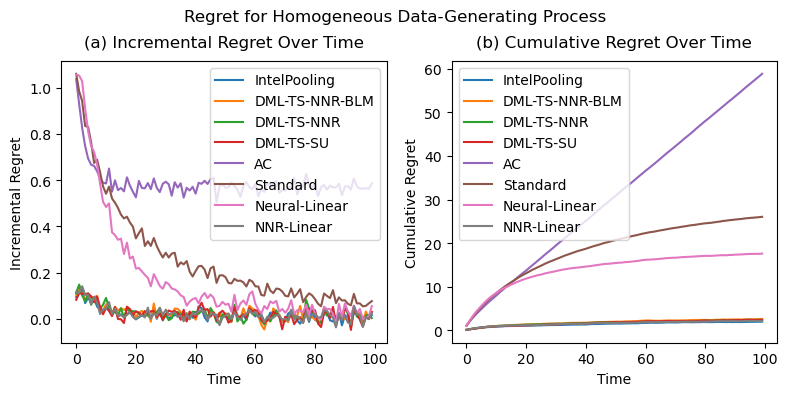

In [17]:
plot_rewards_dict(homogeneous_rewards_dict, "homogeneous")

# Simulation 2: Heterogeneous Users, Linear Baseline, No Time Effects

In [18]:
%%time
heterogeneous_rewards_dict = run_simulation(heterogeneous_data_generator, heterogeneous_featurizer_nn_model, n_jobs=n_jobs)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......input_layer
.........vars
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2024-01-18 17:47:19           64
config.json                                    2024-01-18 17:47:19         2591
variables.h5                                   2024-01-18 17:47:19        19128
Keras model archive loading:
File Name                                             Modified             Size
metadata.json                                  2024-01-18 17:47:18           64
config.json                                    2024-01-18 17:47:18         2591
variables.h5                                 

In [19]:
heterogeneous_rewards_filename = "checkpoints/rectangular_heterogeneous_rewards.pkl"
with open(heterogeneous_rewards_filename, 'wb') as file:
    pickle.dump(heterogeneous_rewards_dict, file, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
with open(heterogeneous_rewards_filename, "rb") as file:
    heterogeneous_rewards_dict = pickle.load(file)

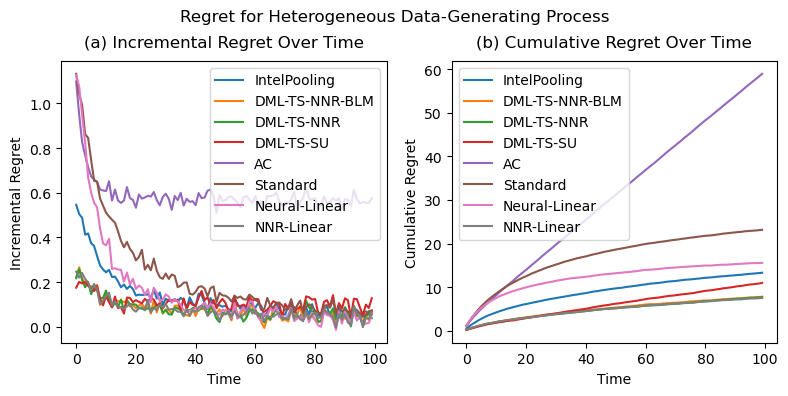

In [21]:
plot_rewards_dict(heterogeneous_rewards_dict, "heterogeneous")

# Simulation 3: Nonlinear Baseline and User-/Time-specific Effects

In [22]:
%%time
nonlinear_rewards_dict = run_simulation(nonlinear_data_generator, nonlinear_featurizer_nn_model, n_jobs=n_jobs)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......input_layer
.........vars
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2024-01-18 18:46:21           64
config.json                                    2024-01-18 18:46:21         2591
variables.h5                                   2024-01-18 18:46:21        19128
Keras model archive loading:
File Name                                             Modified             Size
metadata.json                                  2024-01-18 18:46:20           64
config.json                                    2024-01-18 18:46:20         2591
variables.h5                                 

In [23]:
nonlinear_rewards_filename = "checkpoints/rectangular_nonlinear_rewards.pkl"
with open(nonlinear_rewards_filename, 'wb') as file:
    pickle.dump(nonlinear_rewards_dict, file, protocol=pickle.HIGHEST_PROTOCOL)

In [24]:
with open(nonlinear_rewards_filename, "rb") as file:
    nonlinear_rewards_dict = pickle.load(file)

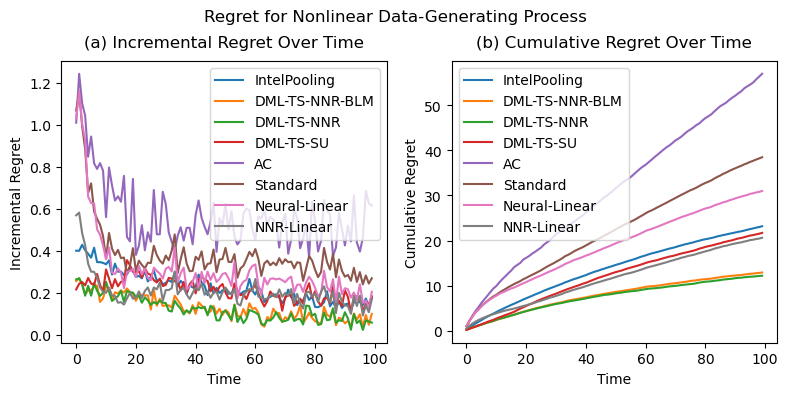

In [25]:
plot_rewards_dict(nonlinear_rewards_dict, "nonlinear")

# Cumulative Regret for All Three Settings

## Calculations

In [26]:
# Calculate incremental regret
incremental_homogeneous_regret_dict = {
    method_name: get_avg_time_reward(homogeneous_rewards_dict["Oracle"]) - get_avg_time_reward(homogeneous_rewards_dict[method_name])
    for method_name in non_oracle_method_names}
incremental_heterogeneous_regret_dict = {
    method_name: get_avg_time_reward(heterogeneous_rewards_dict["Oracle"]) - get_avg_time_reward(heterogeneous_rewards_dict[method_name])
    for method_name in non_oracle_method_names}
incremental_nonlinear_regret_dict = {
    method_name: get_avg_time_reward(nonlinear_rewards_dict["Oracle"]) - get_avg_time_reward(nonlinear_rewards_dict[method_name])
    for method_name in non_oracle_method_names}

# Calculate cumulative regret
cumulative_homogeneous_regret_dict = {method_name: np.cumsum(incremental_homogeneous_regret_dict[method_name], axis=1) for method_name in non_oracle_method_names}
cumulative_heterogeneous_regret_dict = {method_name: np.cumsum(incremental_heterogeneous_regret_dict[method_name], axis=1) for method_name in non_oracle_method_names}
cumulative_nonlinear_regret_dict = {method_name: np.cumsum(incremental_nonlinear_regret_dict[method_name], axis=1) for method_name in non_oracle_method_names}

# Final regret
final_homogeneous_regret_df = pd.DataFrame({
    method_name: cumulative_homogeneous_regret_dict[method_name][:, -1]
    for method_name in non_oracle_method_names})
final_homogeneous_regret_df.to_csv("./checkpoints/rectangular_final_homogeneous_regret.csv", index=False)

final_heterogeneous_regret_df = pd.DataFrame({
    method_name: cumulative_heterogeneous_regret_dict[method_name][:, -1]
    for method_name in non_oracle_method_names})
final_heterogeneous_regret_df.to_csv("./checkpoints/rectangular_final_heterogeneous_regret.csv", index=False)

final_nonlinear_regret_df = pd.DataFrame({
    method_name: cumulative_nonlinear_regret_dict[method_name][:, -1]
    for method_name in non_oracle_method_names})
final_nonlinear_regret_df.to_csv("./checkpoints/rectangular_final_nonlinear_regret.csv", index=False)

## Plots

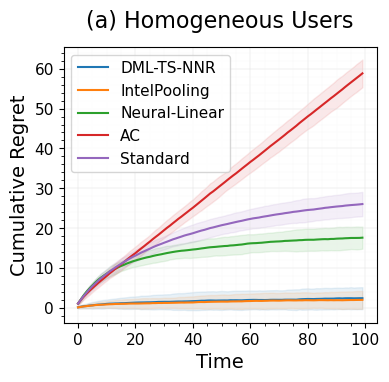

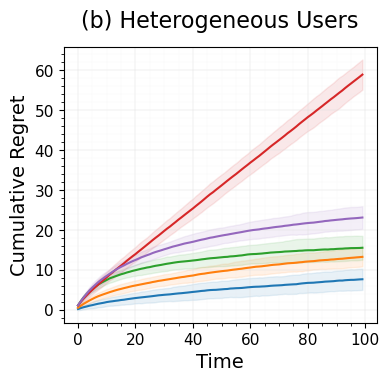

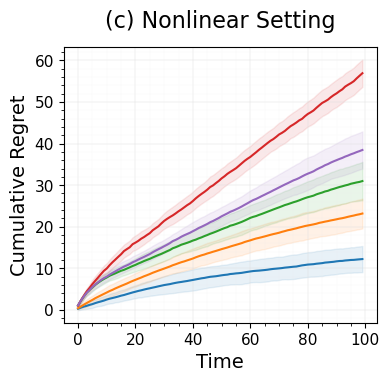

In [27]:
def plot_cumulative_regret(cumulative_regret_dict, setting_name, include_legend=False, loc="main", include_bands=True):
    fig, ax = plt.subplots(1, 1, figsize=(4,4))
    for i, method_name in enumerate(cumulative_regret_dict.keys()):
        color_i = f"C{i}"
        method_means = cumulative_regret_dict[method_name].mean(axis=0)
        method_range = np.arange(method_means.size)
        method_sds = cumulative_regret_dict[method_name].std(axis=0)
        method_lower = method_means - 1.96 * method_sds
        method_upper = method_means + 1.96 * method_sds
        if include_bands:
            ax.fill_between(method_range, method_lower, method_upper, color=color_i, alpha=0.1)
        ax.plot(method_range, method_means, label=method_name, color=color_i)
    ax.grid(which='major', color='#DDDDDD', linewidth=0.3)
    ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.3)
    ax.minorticks_on()
    ax.set_title(setting_name, pad=14, fontsize=16)
    ax.set_ylabel("Cumulative Regret", fontsize=14)
    ax.set_xlabel("Time", fontsize=14)
    ax.tick_params(axis='both', labelsize=11)
    if include_legend:
        ax.legend(fontsize=11)

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    setting_name_for_file = setting_name.replace("(", "").replace(")", "").replace(" ", "-")
    fig.savefig(f"figures/rectangular-cumulative-regret-{setting_name_for_file}-{loc}.png")
    # fig.suptitle("Comparison of Cumulative Regret by Method")
    plt.show()

main_paper_methods = ["DML-TS-NNR", "IntelPooling", "Neural-Linear", "AC", "Standard"]

plot_cumulative_regret(
    {m:cumulative_homogeneous_regret_dict[m] for m in main_paper_methods},
    setting_name="(a) Homogeneous Users", include_legend=True)

plot_cumulative_regret(
    {m:cumulative_heterogeneous_regret_dict[m] for m in main_paper_methods},
    setting_name="(b) Heterogeneous Users", include_legend=False)

plot_cumulative_regret(
    {m:cumulative_nonlinear_regret_dict[m] for m in main_paper_methods},
    setting_name="(c) Nonlinear Setting", include_legend=False)

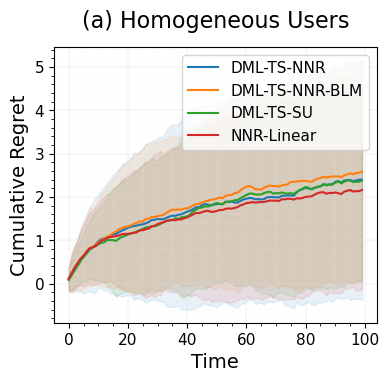

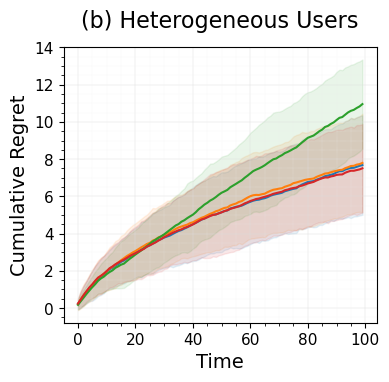

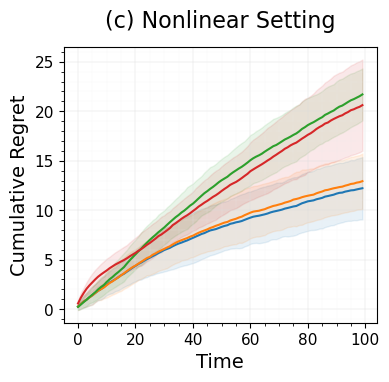

In [28]:
appendix_methods = ["DML-TS-NNR", "DML-TS-NNR-BLM", "DML-TS-SU", "NNR-Linear"]

plot_cumulative_regret(
    {m:cumulative_homogeneous_regret_dict[m] for m in appendix_methods},
    setting_name="(a) Homogeneous Users", include_legend=True, loc="app")

plot_cumulative_regret(
    {m:cumulative_heterogeneous_regret_dict[m] for m in appendix_methods},
    setting_name="(b) Heterogeneous Users", include_legend=False, loc="app")

plot_cumulative_regret(
    {m:cumulative_nonlinear_regret_dict[m] for m in appendix_methods},
    setting_name="(c) Nonlinear Setting", include_legend=False, loc="app")

## Comparison Tables

### Extra

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
final_homogeneous_regret_df = pd.read_csv("./checkpoints/rectangular_final_homogeneous_regret.csv")
final_heterogeneous_regret_df = pd.read_csv("./checkpoints/rectangular_final_heterogeneous_regret.csv")
final_nonlinear_regret_df = pd.read_csv("./checkpoints/rectangular_final_nonlinear_regret.csv")

In [31]:
non_oracle_method_names_sorted = [
    'DML-TS-NNR',
    'DML-TS-NNR-BLM',
    'DML-TS-SU',
    'NNR-Linear',
    'IntelPooling',
    'Neural-Linear',
    'Standard',
    'AC',
]

In [32]:
def create_comparison_df(final_regret_df):
    comparison_outer_list = []
    win_percentages = []
    for method_row in non_oracle_method_names_sorted:
        comparison_inner_list = []
        win_percentage = 0.
        for method_column in non_oracle_method_names_sorted:
            diffs = final_regret_df[method_column] - final_regret_df[method_row]
            percent_row_better = np.mean(diffs > 0)
            avg_diff = np.mean(diffs)
            p_value = ttest_1samp(diffs, popmean=0).pvalue
            if method_row == method_column:
                cell_text = "-"
            else:
                win_percentage += percent_row_better / (len(non_oracle_method_names_sorted) - 1)
                cell_text = f"{percent_row_better:.0%}{'*' if p_value < 0.05 else ''}"
            comparison_inner_list.append(cell_text)
        comparison_outer_list.append(comparison_inner_list)
        win_percentages.append(f"{win_percentage:.0%}")
    comparison_df = pd.DataFrame(
        comparison_outer_list,
        index=[f"{i+1}. {n}" for i, n in enumerate(non_oracle_method_names_sorted)],
        columns=range(1, len(non_oracle_method_names_sorted)+1))
    comparison_df["\textbf{Avg}"] = win_percentages
    latex_table = comparison_df.to_latex(escape=False).replace("%", "\%")
    print(latex_table)
    return comparison_df

In [33]:
homogeneous_comparison_df = create_comparison_df(final_homogeneous_regret_df)
homogeneous_comparison_df

\begin{tabular}{llllllllll}
\toprule
 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 	extbf{Avg} \\
\midrule
1. DML-TS-NNR & - & 54\% & 46\% & 42\% & 40\% & 100\%* & 100\%* & 100\%* & 69\% \\
2. DML-TS-NNR-BLM & 46\% & - & 46\% & 38\%* & 32\%* & 100\%* & 100\%* & 100\%* & 66\% \\
3. DML-TS-SU & 54\% & 54\% & - & 44\% & 34\% & 100\%* & 100\%* & 100\%* & 69\% \\
4. NNR-Linear & 58\% & 62\%* & 56\% & - & 52\% & 100\%* & 100\%* & 100\%* & 75\% \\
5. IntelPooling & 60\% & 68\%* & 66\% & 48\% & - & 100\%* & 100\%* & 100\%* & 77\% \\
6. Neural-Linear & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & - & 100\%* & 100\%* & 29\% \\
7. Standard & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & - & 100\%* & 14\% \\
8. AC & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & - & 0\% \\
\bottomrule
\end{tabular}



,1,2,3,4,5,6,7,8,\textbf{Avg}
1. DML-TS-NNR,-,54%,46%,42%,40%,100%*,100%*,100%*,69%
2. DML-TS-NNR-BLM,46%,-,46%,38%*,32%*,100%*,100%*,100%*,66%
3. DML-TS-SU,54%,54%,-,44%,34%,100%*,100%*,100%*,69%
4. NNR-Linear,58%,62%*,56%,-,52%,100%*,100%*,100%*,75%
5. IntelPooling,60%,68%*,66%,48%,-,100%*,100%*,100%*,77%
6. Neural-Linear,0%*,0%*,0%*,0%*,0%*,-,100%*,100%*,29%
7. Standard,0%*,0%*,0%*,0%*,0%*,0%*,-,100%*,14%
8. AC,0%*,0%*,0%*,0%*,0%*,0%*,0%*,-,0%


In [34]:
heterogeneous_comparison_df = create_comparison_df(final_heterogeneous_regret_df)
heterogeneous_comparison_df

\begin{tabular}{llllllllll}
\toprule
 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 	extbf{Avg} \\
\midrule
1. DML-TS-NNR & - & 56\% & 100\%* & 44\% & 100\%* & 100\%* & 100\%* & 100\%* & 86\% \\
2. DML-TS-NNR-BLM & 44\% & - & 100\%* & 38\% & 100\%* & 100\%* & 100\%* & 100\%* & 83\% \\
3. DML-TS-SU & 0\%* & 0\%* & - & 2\%* & 92\%* & 100\%* & 100\%* & 100\%* & 56\% \\
4. NNR-Linear & 56\% & 62\% & 98\%* & - & 100\%* & 100\%* & 100\%* & 100\%* & 88\% \\
5. IntelPooling & 0\%* & 0\%* & 8\%* & 0\%* & - & 96\%* & 100\%* & 100\%* & 43\% \\
6. Neural-Linear & 0\%* & 0\%* & 0\%* & 0\%* & 4\%* & - & 100\%* & 100\%* & 29\% \\
7. Standard & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & - & 100\%* & 14\% \\
8. AC & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & - & 0\% \\
\bottomrule
\end{tabular}



,1,2,3,4,5,6,7,8,\textbf{Avg}
1. DML-TS-NNR,-,56%,100%*,44%,100%*,100%*,100%*,100%*,86%
2. DML-TS-NNR-BLM,44%,-,100%*,38%,100%*,100%*,100%*,100%*,83%
3. DML-TS-SU,0%*,0%*,-,2%*,92%*,100%*,100%*,100%*,56%
4. NNR-Linear,56%,62%,98%*,-,100%*,100%*,100%*,100%*,88%
5. IntelPooling,0%*,0%*,8%*,0%*,-,96%*,100%*,100%*,43%
6. Neural-Linear,0%*,0%*,0%*,0%*,4%*,-,100%*,100%*,29%
7. Standard,0%*,0%*,0%*,0%*,0%*,0%*,-,100%*,14%
8. AC,0%*,0%*,0%*,0%*,0%*,0%*,0%*,-,0%


### Nonlinear Setting

In [35]:
nonlinear_comparison_df = create_comparison_df(final_nonlinear_regret_df)
nonlinear_comparison_df

\begin{tabular}{llllllllll}
\toprule
 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 	extbf{Avg} \\
\midrule
1. DML-TS-NNR & - & 60\%* & 100\%* & 100\%* & 100\%* & 100\%* & 100\%* & 100\%* & 94\% \\
2. DML-TS-NNR-BLM & 40\%* & - & 100\%* & 100\%* & 100\%* & 100\%* & 100\%* & 100\%* & 91\% \\
3. DML-TS-SU & 0\%* & 0\%* & - & 28\%* & 78\%* & 100\%* & 100\%* & 100\%* & 58\% \\
4. NNR-Linear & 0\%* & 0\%* & 72\%* & - & 86\%* & 100\%* & 100\%* & 100\%* & 65\% \\
5. IntelPooling & 0\%* & 0\%* & 22\%* & 14\%* & - & 98\%* & 100\%* & 100\%* & 48\% \\
6. Neural-Linear & 0\%* & 0\%* & 0\%* & 0\%* & 2\%* & - & 100\%* & 100\%* & 29\% \\
7. Standard & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & - & 100\%* & 14\% \\
8. AC & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & - & 0\% \\
\bottomrule
\end{tabular}



,1,2,3,4,5,6,7,8,\textbf{Avg}
1. DML-TS-NNR,-,60%*,100%*,100%*,100%*,100%*,100%*,100%*,94%
2. DML-TS-NNR-BLM,40%*,-,100%*,100%*,100%*,100%*,100%*,100%*,91%
3. DML-TS-SU,0%*,0%*,-,28%*,78%*,100%*,100%*,100%*,58%
4. NNR-Linear,0%*,0%*,72%*,-,86%*,100%*,100%*,100%*,65%
5. IntelPooling,0%*,0%*,22%*,14%*,-,98%*,100%*,100%*,48%
6. Neural-Linear,0%*,0%*,0%*,0%*,2%*,-,100%*,100%*,29%
7. Standard,0%*,0%*,0%*,0%*,0%*,0%*,-,100%*,14%
8. AC,0%*,0%*,0%*,0%*,0%*,0%*,0%*,-,0%


In [36]:
final_nonlinear_regret_df

,IntelPooling,DML-TS-NNR-BLM,DML-TS-NNR,DML-TS-SU,AC,Standard,Neural-Linear,NNR-Linear
0,20.750056,12.068961,15.008704,19.525555,55.418016,38.858717,27.847177,18.713533
1,23.075972,15.867573,16.510411,20.926204,60.200479,37.268335,35.114764,20.643185
2,22.488947,12.484429,11.723126,23.438839,57.657632,36.369381,30.623297,16.256672
3,23.329528,13.543200,11.709684,22.367533,57.587548,42.192936,33.118140,26.742274
4,25.477184,13.739961,15.481268,22.210265,54.717784,38.816484,29.395881,22.928075
5,22.790752,12.187744,13.266145,25.089796,55.529013,37.424068,34.089116,20.216187
6,26.939415,12.022359,11.523579,19.912069,55.636098,36.685831,24.233639,18.945543
7,24.098015,14.649187,12.667026,22.197028,60.394387,40.218562,30.614879,21.150411
8,23.659394,12.147612,13.767761,20.711964,57.434940,38.943138,30.915596,18.368224
9,22.609428,11.838297,12.389268,21.371757,57.143249,35.887057,32.093429,20.687237


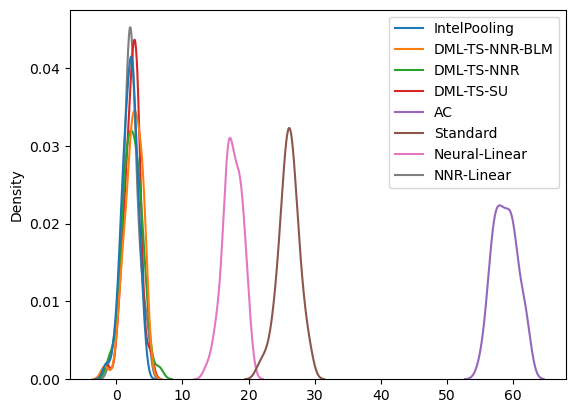

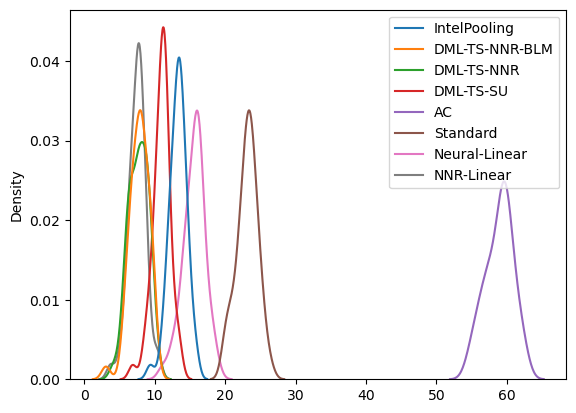

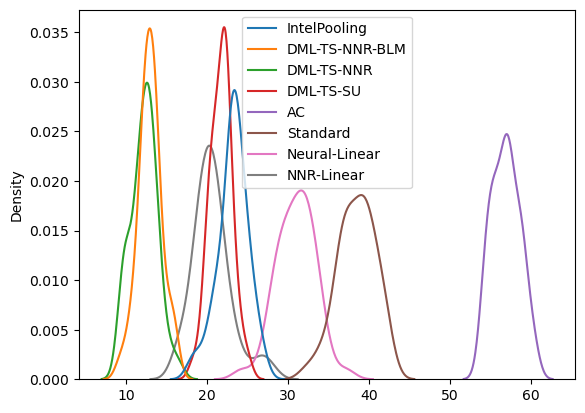

In [37]:
sns.kdeplot(data=final_homogeneous_regret_df)
plt.show()

sns.kdeplot(data=final_heterogeneous_regret_df)
plt.show()

sns.kdeplot(data=final_nonlinear_regret_df)
plt.show()